# Challenge 02: Minimum Hamming Distance using a Quantum Algorithm

**Solution done by [Billy.Ljm](https://github.com/BillyLjm/QOSF-Monthly-Challenges)**  

The Hamming distance between two binary strings (with the same number of bits) is defined as the number positions where the bits differ from each other. For example, the Hamming distance between these $6$-bit strings <span style="color:red">$0$</span>$01$<span style="color:red">$0$</span>$0$<span style="color:red">$1$</span> and <span style="color:red">$1$</span>$01$<span style="color:red">$1$</span>$0$<span style="color:red">$0$</span> is $3$.

A simple way to calculate the Hamming distance between two numbers is to perform a bitwise XOR between them, and count the number of ones in the resulting string:

$$ 001001 \oplus 101100 = 100101 \xrightarrow[]{\; \text{count ones} \;} 011 \text{ (3 in base-2)} $$

The purpose of this challenge is to develop a quantum algorithm that takes as an input an arbitrary number $m$ of $n$-bit strings, and outputs the two strings with the minimum Hamming distance between them with a resonably high probability. How high? the higher the better.

For instance, for the following input of four 4-bit strings: $[0000,1001,1100,1101]$ the algorithm should return strings $[1100,1101]$ since they only differ by one bit.

**Level 1:** Start by only considering the cases in which the answer is unique. In other words, assume that all inputs only have one pair of strings that gives the minimum Hamming distance. So inputs such as $[0000,0001,0010,0111]$ don't have to be considered because there are two solutions: $[0000,0001]$ and $[0000,0010]$.

**Level 2:** Now consider the case where more than one solution can exist and make sure the algorithm returns each of the possible solutions with equal probability. So, for the example above, the probability of measuring $[0000,0001]$ or $[0000,0010]$ should be close to $50\%$ (inputs with repeated strings should also be considered).

**Hint:** Consider looking into some of the "textbook" quantum algorithms (like Deutch-Jozsa (DJ) [1], Bernstein-Vazirani (BV) [2], Grover [3], etc.) to see if this problem can be solved with variations of these. Take for instance this pre-print [4], where a modified version of DJ was used to compute Hamming distances between two strings. Now, keep in mind that in that approach, Hamming weights were calculated using probability distributions (which require multiple runs of the algorithm), and not by amplifying states, as required by this challenge.


[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

[4] Bravo, José Manuel. "Calculating Hamming distance with the IBM Q Experience." Preprints (2018).

## Naive Algorithm: Quantum-Classical
For a (partially) quantum algorithm that works for all data sets:

1. Check for duplicate bit strings, with 0 Hamming distance | $\Theta(m)$ classical runtime
2. Run Grover's algorithm for an assumed Hamming distance of 1 | $\Theta(\sqrt{m^2})$ quantum runtime
3. Check if Grover output has a distance of 1, and is a "true output" | $\Theta(1)$ classical runtime
4. If output is not "true", repeat steps 2-3 for increasing Hamming distances | $\lt n$ iterations

*where $m$ is the number of bit strings, and $n$ is the length of each bit string* 

This algorithm has a runtime of $O(nm)$, versus the classical pair-wise comparison of $O(m^2)$.  
Thus, this quantum approach is more suitable for a large number of relatively short bit strings.    
Additionally if it is guaranteed that $m \gt\gt n$, there is a faster [quantum algorithm](#Informed-Algorithm:-Large-$m$) implemented below.  

However, this algoirhtm isn't explicitly implemented here, since it isnt what the challenge is looking for(?)  
But the Grover algorithm step here only requires minor modification of the [infromed algorithm](#Informed-Algorithm:-Large-$m$) implemented below.  

## Informed Algorithm: Large $m$
My approach is to use 2 address/QRAM registers to perpare 2 identical but unentangled copies of the (superposed) bit strings.  
The Hamming distances are then calculated simply by applying CNOTs across the 2 registers/copies.  
To pick out the minimum distance, Grover's algorithm is used to amplify bit-strings first with distance $\lt 1$, then $\lt 2$, and so on up to $\lt n$.  

However, this only works if the bit strings are not amplified more than the "optimal" number of Grover iterations, which constrains the following.  
This constrains translates practically to a large number of long bit strings since $m \leq 2^n$, which would be the most classically challenging situations anyway.

$$\begin{aligned}
    &n - i \leq \frac{\pi}{4} \sqrt{\frac{m^2}{g_{n-i}}} 
    &\forall \ i \in [1, n]
\end{aligned}$$

*where $m$ is the number of bit strings, $n$ is the length of each bit string, and $g_k$ is the degeneracy of the pairs with $\leq k$ Hamming distance*  

This quantum algorithm has a runtime of $O(n)$, and only works for a large number of relatively short bit strings.  
Alternatively, there is a slower quantum-classical apporach with $O(nm)$ runtime, but which works for all data sets.  
Either way, the classical pairwise comparison has a runtime of $O(m^2)$, and is still more suited for a small number of relatively large bit strings.  

In [1]:
from numpy import pi

import random
import numpy as np
np.set_printoptions(precision=3)

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import XGate, MCMTVChain

In [2]:
def qram_order(n):
    """ optimal order of addresses for QRAM loading
    where progressively more significant bits are flipped between elements
    
    Parameters:
        n (int): length of binary address string
    
    Returns:
        list of strings which denote the address bit string order
    """
    if n < 1:
        return ['']
    else:
        out = qram_order(n-1)
        tmp = []
        for i in range(len(out)):
            tmp.append('1' + out[i])
            out[i] = '0' + out[i]
        return tmp + out
    
# demonstration
qram_order(3)

['111', '110', '101', '100', '011', '010', '001', '000']

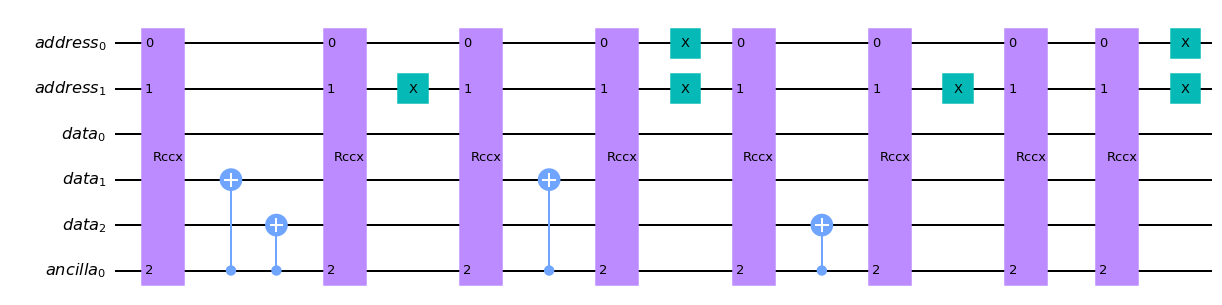

In [3]:
def qram(data):
    """Loads data into address & data quantum registers
    
    Parameters:
        data (list): list of bit strings to load
        
    Returns:
        QuantumCircuit for (naddr) address, (nbits) data, and
        (naddr-1) ancilla registers, sized based on input data.
    """
    # declare variables
    naddr = len(bin(len(data)-1))-2
    nbits = len(data[0])
    qorder = qram_order(naddr)
    
    # 1-bit strings
    if len(data) == 1:
        qdata = QuantumRegister(nbits, 'data')
        qram = QuantumCircuit(qdata, name="qram")
        for i in range(nbits):
            qram.x(qdata[i]) if data[0][i] == '1' else None
    
    # 2-bit strings
    elif len(data) == 2:
        # declare registers
        addresses = QuantumRegister(naddr, 'address')
        qdata = QuantumRegister(nbits, 'data')        
        qram = QuantumCircuit(addresses, qdata, name="qram")
        # load 1st bit string, w/ 0 address
        qram.x(addresses[0])
        for i in range(nbits):
            qram.cx(addresses[0], qdata[i]) if data[0][i] == '1' else None
        # load 1st bit string, w/ 1 address
        qram.x(addresses[0])
        for i in range(nbits):
            qram.cx(addresses[0], qdata[i]) if data[1][i] == '1' else None
        
    # n-bit strings
    else:
        addresses = QuantumRegister(naddr, 'address')
        qdata = QuantumRegister(nbits, 'data')
        ancillae = QuantumRegister(naddr-1, 'ancilla')
        qram = QuantumCircuit(addresses, qdata, ancillae, name="qram")
        
        # iterate through address in optimal sequence
        prvaddr = None # previous caddr (classical address)
        for caddr in qorder:
            
            # find data to load
            dec = int(caddr, 2)
            if dec < len(data):
                cdata = data[dec]
            else:
                continue
                
            # find most significant address bit which flipped
            if prvaddr == None:
                msfdigit = 0
            else:
                for i in range(naddr):
                    if caddr[i] != prvaddr[i]:
                        msfdigit = i
                        break
                    
            # untentangle up to most siginficant bit
            if prvaddr != None:
                for i in reversed(range(msfdigit, naddr)):
                    if i == 0:
                        pass
                    elif i == 1:
                        qram.rccx(addresses[0], addresses[1], ancillae[0])
                    else:
                        qram.rccx(addresses[i], ancillae[i-2], ancillae[i-1])
            
            # prepare address bits
            if prvaddr == None:
                for i in range(naddr):
                    qram.x(addresses[i]) if caddr[i] == '0' else None
            else:
                for i in range(msfdigit, naddr):
                    qram.x(addresses[i]) if caddr[i] != prvaddr[i] else None
            
            
            # re-entangle addresses & ancialle
            for i in range(msfdigit, naddr):
                if i == 0:
                    pass
                elif i == 1:
                    qram.rccx(addresses[0], addresses[1], ancillae[0])
                else:
                    qram.rccx(addresses[i], ancillae[i-2], ancillae[i-1])
            
            # load data
            for i in range(nbits):
                qram.cx(ancillae[-1], qdata[i]) if cdata[i] == '1' else None
            prvaddr = caddr[:]
        
        # clean up
        for i in reversed(range(1,naddr)): # unentangle ancillae
            if i == 0:
                pass
            elif i == 1:
                qram.rccx(addresses[0], addresses[1], ancillae[0])
            else:
                qram.rccx(addresses[i], ancillae[i-2], ancillae[i-1])
        for i in range(naddr): # reverse addresses
            qram.x(addresses[i]) if qorder[-1][i] == '0' else None

    return qram

# draw circuit
qc = qram(['000', '001', '010', '011'])
qc.draw(output="mpl")

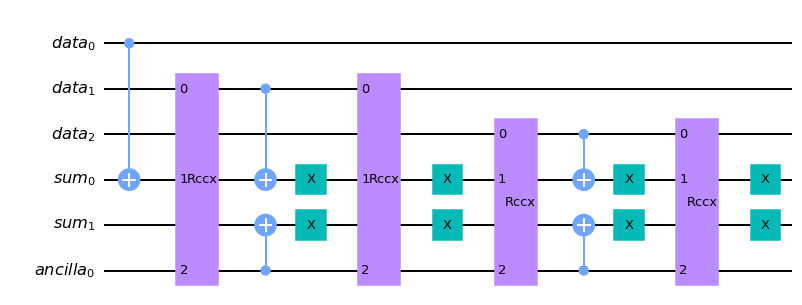

In [4]:
def adder(nbits, clean_ancillae=True):
    """ Counts the number of 1's in a register 
    into another sum register in binary form
    
    Parameters:
        nbits (int): number of input bits to add
        
    Returns:
        QuantumCircuit for (nbits) data qubits, (nsum) sum qubits, 
        and (nsum-1) ancilla qubits; where nsum = len(bin(nbits))-2
    """
    # declare variables
    nsum = len(bin(nbits)[2:])
    
    # declare quantum circuit
    data = QuantumRegister(nbits, 'data')
    summ = QuantumRegister(nsum, 'sum')
    ancillae = QuantumRegister(nsum-1, 'ancilla') if nsum > 1 else None
    adder = QuantumCircuit(data, summ, name='adder') if ancillae == None else \
         QuantumCircuit(data, summ, ancillae, name='adder')
    
    # add 1st bit
    adder.cx(data[0], summ[0])
    # add subsequent qubits
    for i in range(1, nbits):
        # mark where carry-over occurs w/ ancillae
        adder.rccx(data[i], summ[0], ancillae[0])
        for j in range(1, nsum-1):
            adder.rccx(summ[j], ancillae[j-1], ancillae[j])
        # execute carry-over onto sum register
        for j in range(nsum-1):
            adder.cx(ancillae[j], summ[j+1])
        adder.cx(data[i], summ[0])
        # reset ancillae to |00...0>
        adder.x(summ)
        for j in reversed(range(1,nsum-1)):
            adder.rccx(summ[j], ancillae[j-1], ancillae[j])
        adder.rccx(data[i], summ[0], ancillae[0])
        adder.x(summ)
    
    return adder

# draw circuit
qc = adder(3, clean_ancillae=True)
qc.draw(output="mpl")

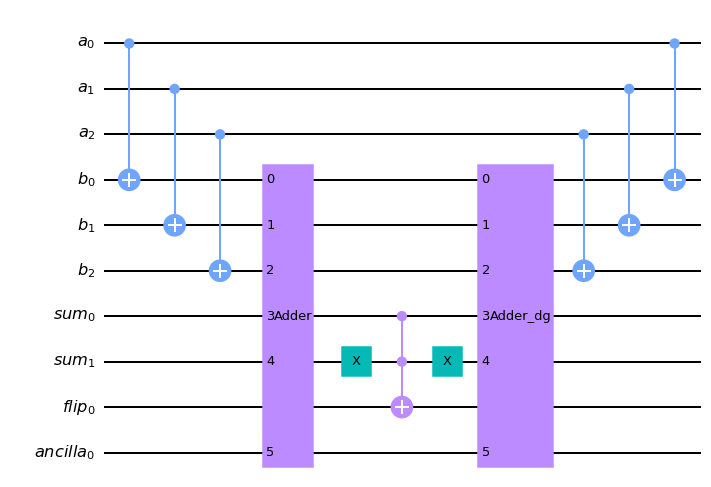

In [5]:
def oracle_hamming(nbits, distances, ancillae_init=False):
    """ Calculates the Hamming distance b/w 2 registers
    and phase flips components with specific distances
    
    Parameters:
        nbits (int): number of bits in each of the 2 registers
        distances (list of int): hamming distances to phase flip
        ancillae_init (bool): True if ancillae initalised to |-0...0>, 
                              False if ancillae intiliased to |00..0>
        
    Returns:
        QuantumCircuit for 2 (nbits) data qubits, (nsum) sum qubits, 
        and (nsum) ancilla qubits; where nsum = len(bin(nbits))-2
    """
    # declare variables
    nsum = len(bin(nbits))-2
    add = adder(nbits)
    
    # declare quantum circuit
    regA = QuantumRegister(nbits, "a")
    regB = QuantumRegister(nbits, "b")
    summ = QuantumRegister(nsum, "sum")
    flip = QuantumRegister(1, 'flip')
    ancillae = QuantumRegister(nsum-1, "ancilla")
    oracle = QuantumCircuit(regA, regB, summ, flip, ancillae, name="oracle_Hamming(%d)"%distances[-1])
    
    # caclulate hamming distance
    for i in range(nbits):
        oracle.cx(regA[i], regB[i])
    oracle.append(add, [*regB, *summ, *ancillae])
    
    # phase flip
    oracle.u(pi/2, pi, pi, flip) if not ancillae_init else None # HX gate
    for dist in distances:
        bdist = bin(dist)[2:]
        bdist = '0' * (nsum - len(bdist)) + bdist
        for i in range(len(bdist)):
            oracle.x(summ[i]) if bdist[-1-i] == '0' else None
        oracle.mcx(summ, flip, ancillae, mode='v-chain')
        for i in range(len(bdist)):
            oracle.x(summ[i]) if bdist[-1-i] == '0' else None
    oracle.u(pi/2, 0, 0, flip) if not ancillae_init else None # XH gate
    
    # uncalculate hamming distance
    oracle.append(add.inverse(), [*regB, *summ, *ancillae])
    for i in reversed(range(nbits)):
        oracle.cx(regA[i], regB[i])
    
    return oracle

qc = oracle_hamming(3, [1], ancillae_init=True)
qc.draw(output="mpl")

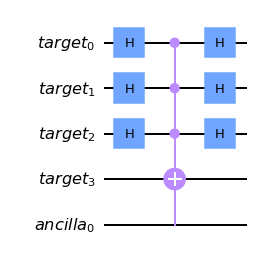

In [6]:
def diffuse(nbits, start='+'):
    """Grover diffusion circuit
    
    Parameters:
        nbits (int): number of qubits to diffuse
        start (bool): target register intial state. '0' for |0>|0>... (speed: 1 > - > 0 > +)
    
    Returns:
        QuantumCircuit for (nbits) target qubits, and (nbits-3) ancilla qubits
    """
    # declare quantum circuit
    targets = QuantumRegister(nbits, 'target')
    ancillae = QuantumRegister(nbits-3, 'ancilla') if nbits > 3 else None
    diffuse = QuantumCircuit(targets, name="Diffuse") if ancillae == None \
        else QuantumCircuit(targets, ancillae, name="Diffuse")
    
    # transfrom state to |11...1->, phase flip, and reverse tranformation
    if nbits == 1:
        qc.z(targets)
    elif start == '1':
        diffuse.h(targets[-1])
        diffuse.mcx(targets[:-1], targets[-1], ancillae, mode='v-chain')
        diffuse.h(targets[-1])
    elif start == '-':
        diffuse.h(targets[:-1])
        diffuse.mcx(targets[:-1], targets[-1], ancillae, mode='v-chain')
        diffuse.h(targets[:-1])
    elif start == '0':
        diffuse.u(pi/2, pi, pi, targets[-1]) # HX gate
        diffuse.x(targets[:-1])
        diffuse.mcx(targets[:-1], targets[-1], ancillae, mode='v-chain')
        diffuse.x(targets[:-1])
        diffuse.u(pi/2, 0, 0, targets[-1]) # XH gate
    elif start == '+':
        diffuse.u(pi/2, 0, 0, targets[:-1]) # XH gate
        diffuse.z(targets[-1])
        diffuse.mcx(targets[:-1], targets[-1], ancillae, mode='v-chain')
        diffuse.z(targets[-1])
        diffuse.u(pi/2, pi, pi, targets[:-1]) # HX gate

    return diffuse

# draw circuit
qc = diffuse(4, start="-")
qc.draw(output="mpl")

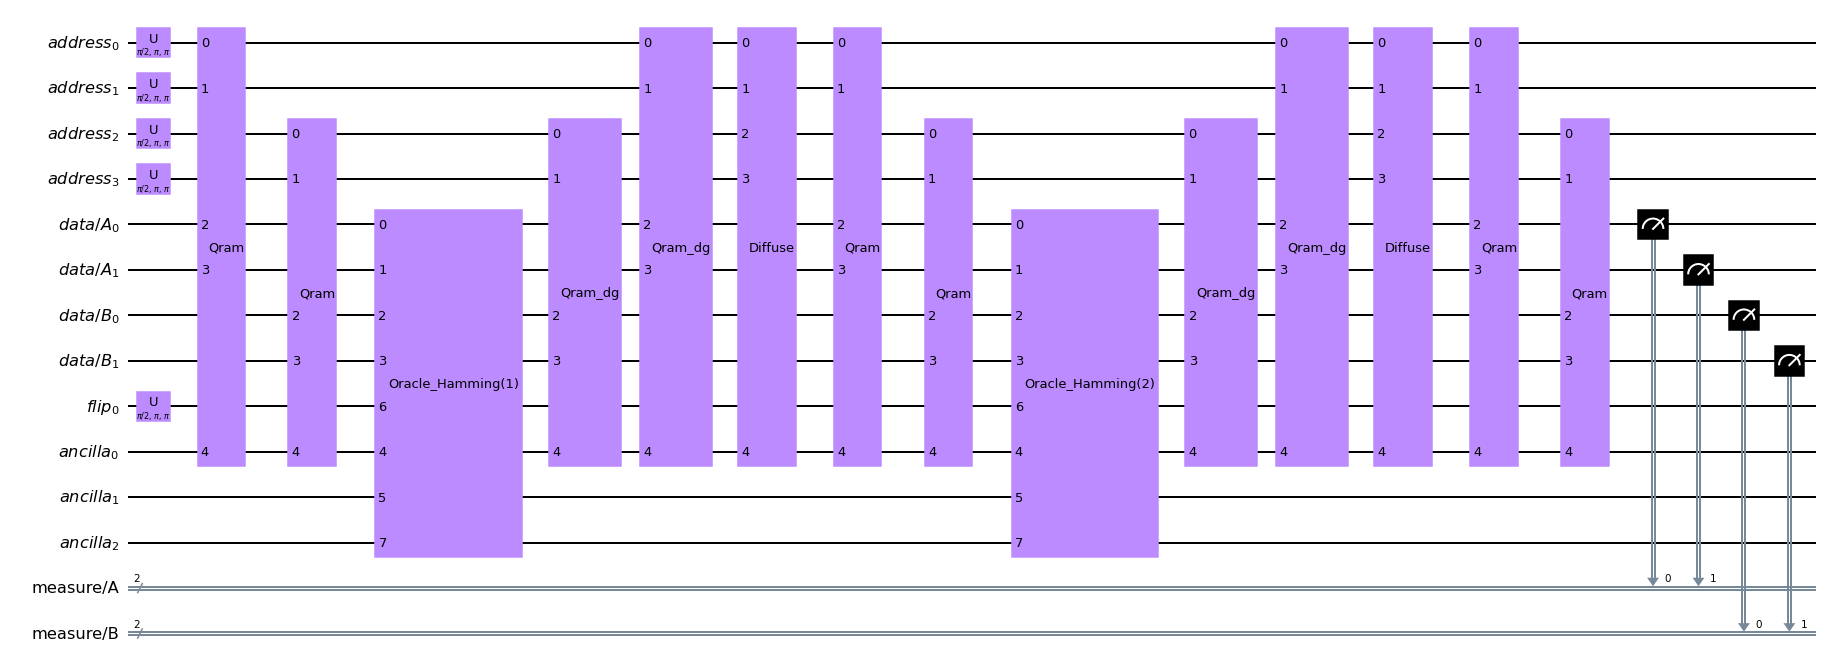

In [7]:
def min_hamming(data):
    """ Finds the pair of bit-string in data w/ minimum Hamming distance
    Assumes len(data[0]) <= (pi * len(data))/(4 * 2 * sqrt(k)),
    where k is the number of unique pairs with the same minimum distance
    
    Parameters:
        data (list): list of bit strings to find minimum Hamming distance within
    
    Returns:
        QuantumCircuit for 2 address qubits, (nrows * ncols) lights register,
        (nrows * ncols) switches register, (nrows * ncols - 2) + 3 auxiliary 
        |0> qubits, and (nrows * ncols) classical measurement register
    """    
    # declare variables
    naddr = len(bin(len(data)-1))-2
    nbits = len(data[0])
    nsum = len(bin(nbits))-2
    
    # pad data to fully fill addresses
    tmp = data[:]
    for i in range(len(tmp), 2**naddr):
        data.append(tmp[i - len(tmp)])
    
    # subcircuits
    qram_circ = qram(data)
    #oracle_circ = oracle_hamming(nbits, [1], ancillae_init=True)
    oracle_circs = [oracle_hamming(nbits, list(range(1,i+2)), ancillae_init=True) for i in range(nbits)]
    diff_circ = diffuse(2*naddr, start='-')
    
    # quantum circuit
    addresses = QuantumRegister(2*naddr, 'address') # address of bit string pairs
    dataA = QuantumRegister(nbits, 'data/A') # 1st copy of data
    dataB = QuantumRegister(nbits, 'data/B') # 2nd copy of data
    flip = QuantumRegister(1, 'flip') # for oracle phase flip
    ancillae = QuantumRegister(max(naddr-1, 2*nsum-1, 2*naddr-3), 'ancilla')
    measureA = ClassicalRegister(nbits, 'measure/A') # to measure dataA
    measureB = ClassicalRegister(nbits, 'measure/B') # to measure dataAB
    minham = QuantumCircuit(addresses, dataA, dataB, flip, ancillae, measureA, measureB)

    # initialise qubits
    minham.u(pi/2, pi, pi, addresses) # |->, start='-' in diffuse
    minham.u(pi/2, pi, pi, flip) # for oracle phase flips
    
    # Grover algorithm
    for i in  range(nbits):
        minham.append(qram_circ, [*addresses[:naddr], *dataA, *ancillae[:naddr-1]])
        minham.append(qram_circ, [*addresses[naddr:], *dataB, *ancillae[:naddr-1]])
        minham.append(oracle_circs[i], [*dataA, *dataB, *ancillae[:nsum], *flip, *ancillae[nsum:max(2*nsum-1, nsum+nbits-3)]])
        minham.append(qram_circ.inverse(), [*addresses[naddr:], *dataB, *ancillae[:naddr-1]])
        minham.append(qram_circ.inverse(), [*addresses[:naddr], *dataA, *ancillae[:naddr-1]])
        minham.append(diff_circ, [*addresses, *ancillae[:2*naddr-3]])
        
    # output
    minham.append(qram_circ, [*addresses[:naddr], *dataA, *ancillae[:naddr-1]])
    minham.append(qram_circ, [*addresses[naddr:], *dataB, *ancillae[:naddr-1]])
    minham.measure(dataA, measureA)
    minham.measure(dataB, measureB)
    return minham

# draw circuit
qc = min_hamming(['00', '01', '10', '11'])
qc.draw(output="mpl", fold=50)

### Test Cases
It is pretty hard to find test cases with small depth circuits which also satisfy the algorithm's above-mentioned constraint.  
This is because longer bit strings have more diversity, which helps with choosing more strings with Hamming distances that do not overlap too much.  
However, longer bit strings leads to not only more bits but also more Grover iterations which makes simulations a lot slower or even impractical.  

Additionally, since the QRAM has to automatically pad the data to fill up all its addresses,  
the resulting extra degeneracy will also have to be factored in when choosing a number of bit strings $m \neq 2^n$

Thus, test cases will likely have to be handpicked and not as comprehensive, like the example I've given here.  
The most easily simultable cases seems to be a minimum Hamming distance of 1 in an 8-string set of 5-bit strings.  
But even then, it requires pre-validation (or eyeballing) of the set to ensure it fufills the algorithm's criteria. 

In [8]:
def minhamdist(dist, nbits, seed=0):
    """ Generates a set of bit strings 
    with a specified minimum Hamming distance
    
    Parameters:
        dist (int): minimum Hamming distance
        nbits (int): lenght of each bit string
        seed (int, optional): seeds the generation
    
    Returns:
        list of bit strings
    """
    out = [seed]
    for i in range(2**nbits):
        hamdist = [bin(i^j).count('1') for j in out]
        if min(hamdist) >= dist:
            out.append(i)
    out = [format(i, '0%db'%nbits) for i in out]
    return out
        
# demonstration
print(minhamdist(2, 5))

['00000', '00011', '00101', '00110', '01001', '01010', '01100', '01111', '10001', '10010', '10100', '10111', '11000', '11011', '11101', '11110']


In [9]:
# Hand-picked test case
## minimum Hamming distance: 1
## correct output: ['01001', '11001'], ['11110', '11111']
data = ['00000', '00011', '00101', '00110', '01001', '11001', '11110', '11111']

qc = min_hamming(data)
qc = qc.reverse_bits()

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
counts = job.result().get_counts()
counts_desc = sorted(counts.items(), key = lambda x: x[1], reverse=True)
print(counts_desc[:5])

[('11111 11110', 901), ('11001 01001', 845), ('01001 11001', 835), ('11110 11111', 768), ('00110 00110', 296)]
